<a href="https://colab.research.google.com/github/Lexie-v2/Goggle-CO/blob/main/Redes_Neuronales_Artificiales_Vera_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción a Keras: Implementando una RNA para clasificar imagenes

IMPLEMENTACIÒN DE UNA RED NEURONAL ARTIFICIAL

##0. Importaciòn de librerias

Como primer paso, vamos a importar las librerias especificas necesarias pra la implementaciòn de la Red Neuronal Artificial, en este caso usaremos el framework **Keras**

Procedemos con la instalaciòn de Keras mediante el paquete de **keras-core**

In [ ]:
#!pip install keras-core

Con la nueva version de Keras, podemos escoger que backend vamos a utilizar, debemos tener en cuenta que por defecto se selecciona **tensorflow**, sin embargo, tenemos disponibles otros backends como **pytorch** o **jax**.
No olvidar que el backend debe configurarse antes de importar Keras y no puede cambiarse despues de la importaciòn.

In [ ]:
#import os
#os.environ["KERAS_BACKEND"] = "torch"

Importamos Keras con el backend seleccionado

In [ ]:
# import keras_core

Otra opcion es utilizar Keras desde el framework Tensorflow. Si el backend que vamos a utilizar es Tensorflow, esta opcion està màs optimizada y suele proporcionar mejores resultados.

Tanto Keras-core como la versión de Keras que se encuentra en framework Tensorflow son totalmente compatibles y no requieren modificaciones en la implementación del programa..

In [ ]:
from tensorflow import keras
#Verificamos si el backend (Tensorflow) està utilizando la GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

##1. Preparacion del conjunto de datos de entrenamiento

Descargamos el conjunto de datos de imagenes. En este caso practico vamos a ahacer uso de conjunto de datos "Dogs vs Cats" de Kaggle.

El conjunto de datos contiene 25000 imagenes de perros y gatos. El objetivo es entrenar una RNA profunda utilizando estos rchivos para que sea capaz de clasificar nuevas imagenes en funciòn de si aparece un perro y un gato.

In [ ]:
# Descargamos el conjunto de datos en el almacenamiento temporal de Google Colab
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
# Descomprimimos el conjunto de datos
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   229M      0  0:00:03  0:00:03 --:--:--  229M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Montamos

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Guardamos el conjunto de datos en el almacenamiento persistente de Google Drive
!unzip -d /content/drive/MyDrive/data_IA kagglecatsanddogs_5340.zip

###1.2. Limpieza de datos

Cuando trabajamos con un conjunto de daos reales, suele pasar que algunos de los ejemplos esten corruptos o incompletos y haya que eliminarlos.

En este caso, debemos recorrr el conjunto de datos buscando imagenes que no se encuentren en el formato adecuado.

In [ ]:
#Ruta de conjunto de datos
DATASET_PATH = "/content/PetImages"

import tensorflow as tf
import os

def filter_images():
  deleted_imgs = 0
  for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(DATASET_PATH, folder_name)
    for image in os.listdir (folder_path):
      img_path = os.path.join(folder_path, image)
      try:
        fobj = open(img_path, "rb")
        # Comprobamos si la imagen esta en formato JPEG
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        deleted_imgs += 1
        # Eliminamos la imagen correspondiente
        os.remove(img_path)
        print(f"Imágenes eliminadas: {deleted_imgs}")

filter_images()

###1.3. Creación de un Dataset con Keras

Otro de los aspectos importantes cuando utilizamos un conjunto de datos de imágenes es normalizar su tamaño. Lo habitual cuando trabajamos con imágenes reales es que tengan diferentes tamaños.

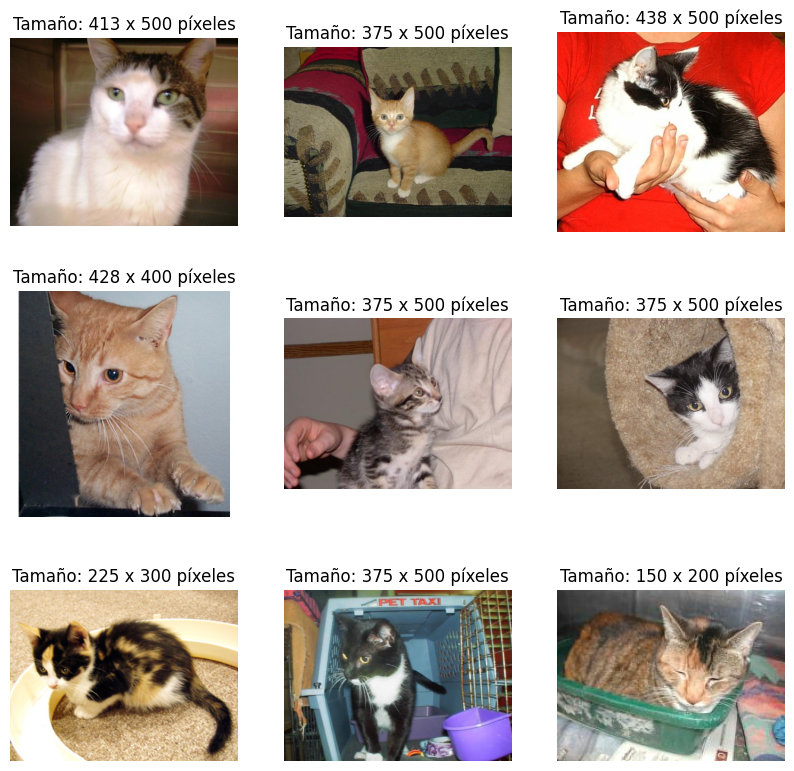

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plt.figure(figsize=(10, 10))
folder_path = os.path.join(DATASET_PATH, "Cat")
for i, image in enumerate(os.listdir(folder_path)[:9]):
    img_path = os.path.join(folder_path, image)
    img = mpimg.imread(img_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} píxeles")
    plt.axis("off")

plt.show()

Keras nos permite normalizar el tamaño de las imágenes de nuestro conjunto de datos haciendo uso de funciones auxiliares que convierten
los datos a un objeto Dataset de los diferentes backends que estemos utilizando.

Tensorflow: https://www.tensorflow.org/api.docs/python/tf/data/Dataset

In [ ]:
image_size = (180, 180)
batch_size = 128 # Tamaño de lote

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2, # 20% de los datos forman parte del subconjunto de validación
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


Podemos observar que las imágenes tienen el mismo tamaño.

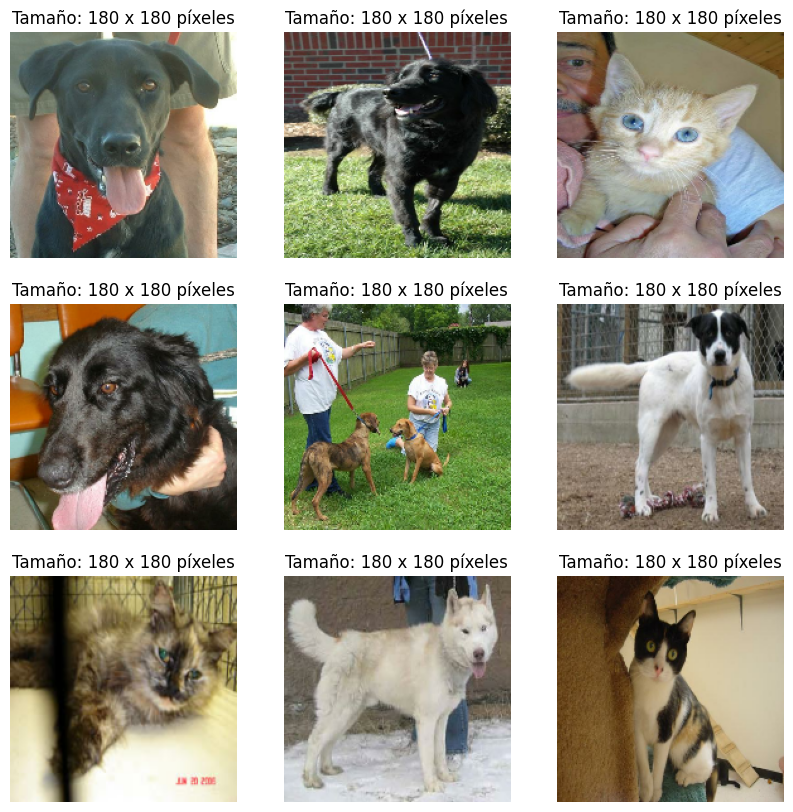

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1): # take(1) obtiene un lote del conjunto de datos (128 ejemplos)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Tamaño: {images[i].shape[0]} x {images[i].shape[1]} píxeles")
        plt.axis("off")

plt.show()

### 1.4. Separación de la etiqueta (label)

Por norma general, las redes neuronales artificiales profundas suelen corresponderse con técnicas de Machine Learning basadas en aprendizaje supervisado.

Esto quiere decir, que durante el proceso de entrenamiento o aprendizaje van a requerir un conjunto de datos etiquetado.

Un conjunto de datos etiquetado se caracteriza porque está formado por los elementos de entrada (en este caso las imágenes) y los elementos de salida o etiqueta (en este caso el valor 0 si aparece un gato en la imagen y 1 si aparece un perro).

El objetivo de la RNA es aprender lo suficiente del conjunto de datos de entrenamiento para poder recibir imágenes que no se encuentran en el conjunto de datos y predecir de manera autónoma la etiqueta.

La función de Keras que hemos utilizado anteriormente ha etiquetado las imágenes en función de la carpeta en la que se encontraban.

Número de imágenes en el batch: 128
Etiquetas del batch: [0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1
 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0
 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0]


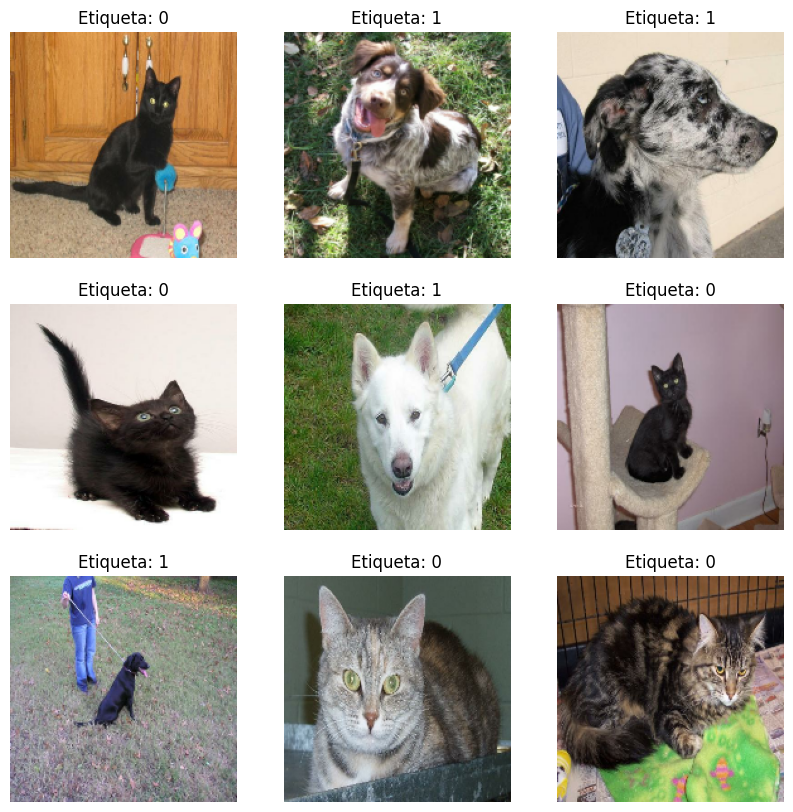

In [ ]:
# El conjunto de datos de entrenamiento está formado por 147 batches
len(train_ds)

# Cada batch está formado por 128 imágenes y sus correspondientes etiquetas
batch1 = list(train_ds.take(1))
batch1

print(f"Número de imágenes en el batch: {len(batch1[0][0])}")
print(f"Etiquetas del batch: {batch1[0][1]}")

# Mostramos dos imágenes del batch con su etiqueta
plt.figure(figsize=(10, 10))

for img, etiqueta in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(f"Etiqueta: {etiqueta[i]}")
        plt.axis("off")

plt.show()


### 1.5. División del conjunto de datos

Cuando abordamos la resolución de un problema real aplicando Inteligencia Artificial / Machine Learning / Deep Learning, debemos dividir el conjunto de datos en 3 subconjuntos:

*   Subconjunto de entrenamiento (train_ds): Contiene aproximadamente el 60-80% de los datos. Este subconjunto se utiliza para entrenar el algoritmo.
*   Subconjunto de validación (val_ds): Contiene aproximadamente el 10-20% de los datos. Se utiliza para validar el comportamiento del algoritmo durante el proceso de entrenamiento.
*   Subconjunto de pruebas (test_ds): Contiene aproximadamente el 10-20% de los datos. Este subconjunto se utiliza para validar el comportamiento del algoritmo final entrenado. Su función es determinar si el modelo se comporta correctamente con ejemplos que no ha visto antes.

Esta división nos ayuda a evitar problemas graves como el sobreentrenamiento (*overfitting*).

Keras nos proporciona una manera sencilla de dividir el conjunto  de datos en entrenamiento y validación.


In [ ]:
# Obtenemos el subconjunto de validación
temp_val_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,  # 20% de los datos forman parte del subconjunto de validación
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Ahora que tenemos el subconjunto de validación (20% de los datos), vamos a subdividirlo en validación y pruebas:

In [ ]:
# Dividimos el conjunto de validación en validación y prueba
val_size = int(0.5 * len(temp_val_ds))  # 50% para validación, 50% para pruebas
val_ds = temp_val_ds.take(val_size)
test_ds = temp_val_ds.skip(val_size)

# Verificamos el número de elementos en cada subconjunto
print(len(val_ds))
print(len(test_ds))


18
19


Existen otras formas más específicas de dividir el conjunto de datos si necesitamos aplicar transformaciones concretas.

Una de las mejores funciones que hay para realizar esta tarea es train_test_split de Sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Idealmente se debe abordar esta fase de división del conjunto de datos con precisión y rigurosidad. Puede ser una fase separada de la implementación del ejercicio y debe buscarse la manera de que la división no afecte a la tendencia del conjunto de datos.



In [ ]:
# train_test_split no puede trabajar con objetos Dataset de Tensorflow
# Esto supone un incremento del consumo de memoria RAM
val_ds_sk = list(temp_val_ds)

from sklearn.model_selection import train_test_split

# División del conjunto de validación en validación y prueba
val_ds_sk, test_ds_sk = train_test_split(
    val_ds_sk,
    test_size=0.5,  # Porcentaje para prueba
    random_state=42,  # Semilla para reproducibilidad
)

len(val_ds_sk)

len(test_ds_sk)

19

### 1.6. Lectura de conjuntos de datos externos - Hugging Face


En las secciones anteriores hemos visto cómo podemos preparar un conjunto de datos desde cero.  
Sin embargo, en algunas ocasiones es posible que ya existan conjuntos de datos preparados que podamos utilizar para resolver el problema específico al que nos enfrentamos.  

Por ejemplo, en **Hugging Face** podemos encontrar un conjunto de datos muy parecido al que hemos preparado nosotros para resolver este caso práctico: [https://huggingface.co/datasets/cats_vs_dogs](https://huggingface.co/datasets/cats_vs_dogs)



In [38]:
!pip install datasets

In [39]:
from datasets import load_dataset
ds = load_dataset("cats_vs_dogs")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})


##2. Definicion de la arquitectura de la Red Neuronal Artificial

Tal y como podéis observar en la definición de la Red Neuronal Artificial que se muestra a continuación, el bloque básico que utiliza Keras es la layer o capa.

La red Neuronal estará formada por diferentes capas que a su vez contendrán un conjunto de neuronas. El número de neuronas se corresponde con el primer parámetro que se le proporciona a la capa.

Vamos a comenzar definiendo una arquitectura muy sencilla. Se corresponde con una Red Neuronal Artificial densamente conectada con los siguientes componentes:

- La primera capa estará formada por 384 neuronas
- La segunda capa estará formada por 256 neuronas
- La tercera capa estará formada por 128 neuronas
- La última capa estará formada por 1 neurona

Diagrama: https://alexlenail.me/NN-SVG/index.html


In [ ]:
from keras import layers

input_shape = (180, 180, 3) # Dimensión de las imágenes

fcnn_model = keras.Sequential()

# Entrada de la red neuronal
fcnn_model.add(layers.Input(shape=input_shape))

# Escalamos las imágenes
fcnn_model.add(layers.Rescaling(1.0 / 255))

# Aplana las imágenes para la primera capa densa
fcnn_model.add(layers.Flatten())

# Layer 1
fcnn_model.add(layers.Dense(384, activation='relu'))

# Layer 2
fcnn_model.add(layers.Dense(256, activation='relu'))

# Layer 3
fcnn_model.add(layers.Dense(128, activation='relu'))

# Layer 4
fcnn_model.add(layers.Dense(1, activation='sigmoid')) # Softmax


Una vez definida la arquitectura de la Red Neuronal Artificial podemos visualizarla junto con el número total de parámetros utilizando el método summary()

In [ ]:
fcnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 97200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │    37,325,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,456,769 (142.89 MB)

 Trainable params: 37,456,769 (142.89 MB)

 Non-trainable params: 0 (0.00 B)

###2.2. Acceso a llos elementos definidos de la RNA

In [ ]:
fcnn_model.layers

[<Rescaling name=rescaling, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

En este caso vamos a acceder a los parámetros del modelo que componen las neuronas de la priemra hidden layer

In [ ]:
hidden1 = fcnn_model.layers[2]
weights, biases = hidden1.get_weights()

Como se puede observar en las celdas siguientes, Keras automaticamente inicializa el valor de los parámetros de manera aleatoria y los bias term con el valor 0

In [ ]:
weights

array([[-0.00464329,  0.00290888,  0.00403139, ...,  0.00464982,
         0.0062184 , -0.00413096],
       [-0.00750818,  0.00202707, -0.00582874, ..., -0.00400036,
         0.00297614, -0.00243268],
       [ 0.0031207 ,  0.00579212, -0.00458201, ..., -0.00659419,
        -0.00190106,  0.00340431],
       ...,
       [ 0.00119045, -0.00586994, -0.00598954, ...,  0.00115942,
        -0.00136542, -0.00384773],
       [ 0.00767626,  0.0042789 ,  0.0070074 , ...,  0.00200524,
        -0.00473571, -0.00282746],
       [-0.0039421 ,  0.00668245,  0.00027396, ...,  0.00508438,
         0.00164018,  0.00591643]], dtype=float32)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

##3. Configuracion de la red Neuronal Artificial

Para que la Red Neuronal Artificial funcione adecuadamente, va a requerir tres componentes adicionales que se seleccionan durante el proceso de compilación:

1. **La función de error**: Se utiliza en el proceso de optimización de los parámetros del modelo para medir el error producido al modificar los parámetros en una dirección determinada.
2. **La función de optimización**: Se encarga de actualizar el valor de los parámetros en una dirección determinada según el resultado de la función de error.
3. **Métricas para monitorear el proceso de entrenamiento**: Nos permiten saber en cada iteración si el valor de los parámetros del modelo es adecuado o si se están produciendo problemas como *overfitting*.



In [ ]:
# Compilamos el primer modelo de FCNN
fcnn_model.compile(
    loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy']
)

##4. Entrenamiento de la Red Neuronal Artificial

En este punto, ya estamos listos para entrenar nuestra Red Neuronal Artificial invocando el método fit(). Keras nos permite integrar el proceso de validación dentro del entrenamiento proporcionando el subconjunto de validación junto con el de entrenamiento.
history = fcnn_model.fit(train_ds, epochs=1, validation_data=val_ds)


In [ ]:
history = fcnn_model.fit(train_ds, epochs=1, validation_data=val_ds)
print(history.history)

147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 224ms/step - accuracy: 0.5053 - loss: 5.8255 - val_accuracy: 0.5421 - val_loss: 0.6958
{'accuracy': [0.518528401851654], 'loss': [2.640716314315796], 'val_accuracy': [0.5421006679534912], 'val_loss': [0.6958072185516357]}


En la variable history se almacenan varios valores importantes:
- El valor de los parámetros del modelo después del entrenamiento.
- La lista de epochs llevadas a cabo.
- Un diccionario con el error producido en cada epoch en los conjuntos de datos de entrenamiento y validación.


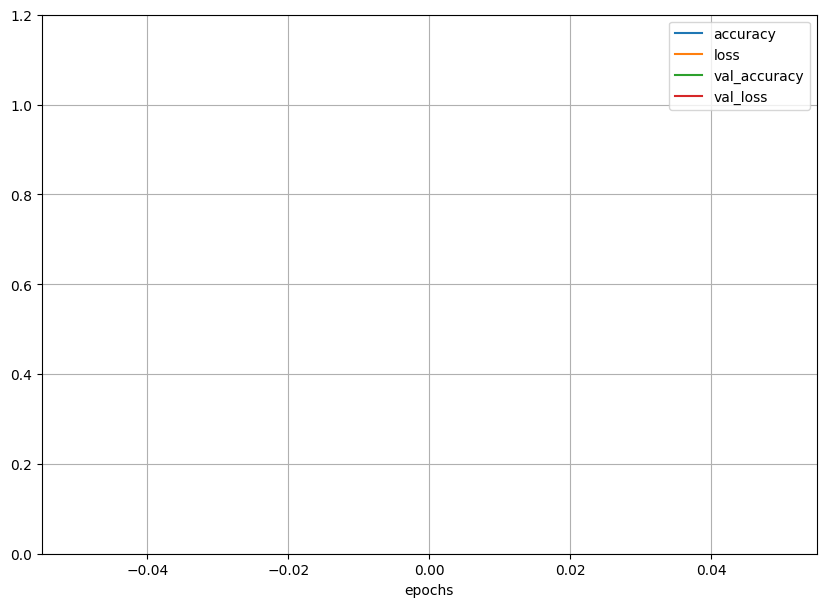

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

Debido a que en la grafica anterior se observa que el error en el conjunto de datos y de validación sigue disminuyendo, podemos continuar entrenando el algoritmo invocando nuevamente el método fit(). Keras continuara el entrenamiento en el punto en el que lo dejó

##5. Guardar el modelo en disco



Con Keras generamos la arquitectura de la red neuronal, la entrenamos y después la evaluamos. Existen diferentes alternativas a la hora de exportar el modelo entrenado (https://keras.io/getting_started/faq/#what-are-my-options-for-saving-models), en este caso se expone una de las más utilizadas.

De la forma que se indica a continuación, vamos a exportar en un fichero los siguientes componentes de la red neuronal:
- La arquitectura del modelo
- Los parámetros del modelo
- Los hiperparámetros del modelo
- Las métricas


In [ ]:
# Guardamos el modelo en disco
fcnn_model.save("modelo_fcnn_cats_vs_dogs.keras")


Una vez ejecutada la celda anterior, generará un fichero modelo_fcnn_cats_vs_dogs que puede utilizarse para transportarlo a otro sistema y predecir con nuevos ejemplos. La forma en la que puedes importar este fichero para predecir con nuevos ejemplos es la siguiente:


In [ ]:
# Cargamos el modelo de disco
fcnn_model_disk = keras.models.load_model("modelo_fcnn_cats_vs_dogs.keras")

##6. Prediccion de nuevos ejemplos

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.5589 - loss: 0.6881
Loss: 0.684182345867157
Accuracy: 0.5639192461967468
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

<ipython-input-26-bce21e83deb8>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


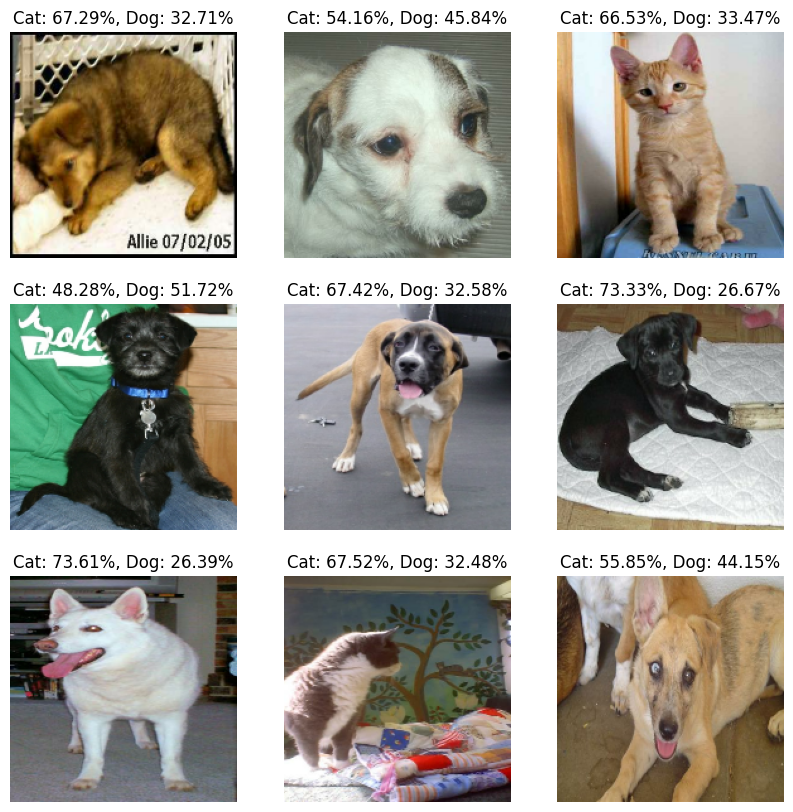

In [ ]:
# Evaluación del modelo entrenado con el conjunto de datos de prueba
evaluation_result = fcnn_model_disk.evaluate(test_ds)

# Mostramos las métricas de evaluación
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Predicción con nuevos ejemplos
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1): # Obtiene un lote de datos
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = fcnn_model_disk.predict(tf.expand_dims(images[i], 0))
        score = float(predictions[0])
        plt.title(f"Cat: {100 * (1 - score):.2f}%, Dog: {100 * score:.2f}%")
        plt.axis("off")

plt.show()


##7. Mejorando los resultados obtenidos

###7.1. ¿Qué cosas podemos mejorar?
Cuando los resultados que obtenemos no son lo suficientemente buenos, debemos centrarnos en iterar sobre diferentes componentes de nuestro proyecto:

1. **Conjunto de datos**: Es posible que los datos obtenidos no sean de suficiente calidad o no sean suficientes. Podemos aplicar técnicas para aumentar el tamaño de nuestro conjunto de datos.

2. **Arquitectura de la Red Neuronal**: La arquitectura de la Red Neuronal Artificial puede no ser adecuada para el problema que queremos resolver.

3. **Configuración de la Red Neuronal**: La configuración de la Red Neuronal Artificial puede no ser adecuada para el problema y la arquitectura seleccionados.



###7.2. **Aumento del conjunto de datos (Data Augmentation)**
*Data augmentation*, o aumento de datos, es una técnica utilizada comúnmente en aprendizaje automático y visión artificial para mejorar el rendimiento de un modelo mediante la generación de variaciones artificiales en los datos de entrenamiento.

El objetivo principal es ampliar el conjunto de datos de entrenamiento, proporcionando más diversidad y variabilidad para que el modelo pueda aprender patrones más robustos y generalizar mejor a datos nuevos.


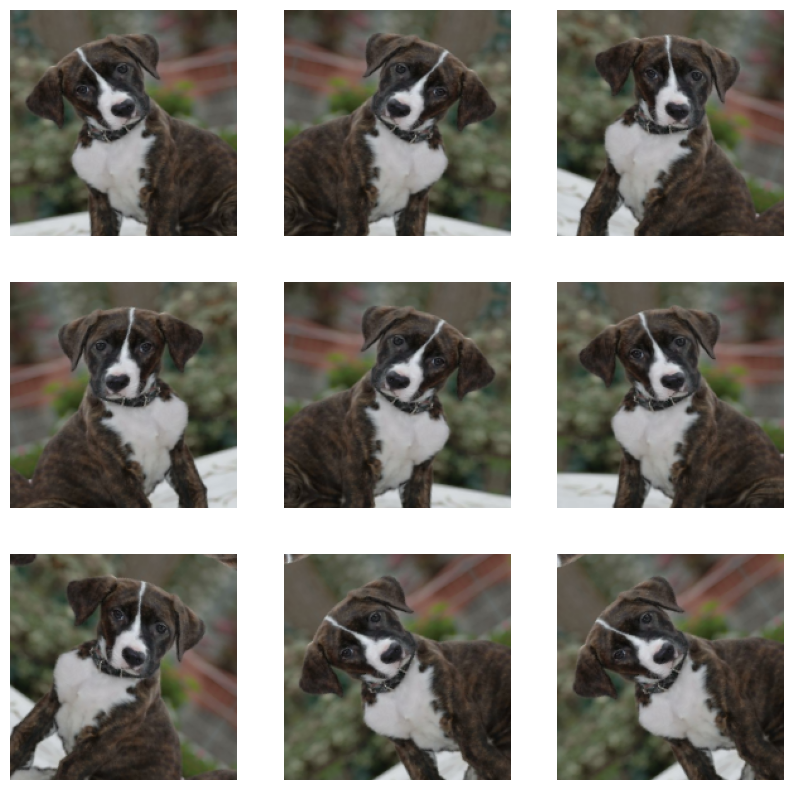

In [ ]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

import tensorflow as tf

# Aplicamos "data augmentation" al conjunto de datos de entrenamiento
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)


###7.3. Arquitectura de la RNA: API Funcional

La arquitectura de RNA definida anteriormente es correcta y nos permite resolver tareas de clasificación de imágenes. Sin embargo, no es la arquitectura óptima para esta tarea.

Ahora que ya sabemos definir los componentes de una RNA con Keras, vamos a profundizar sobre otras capas más eficaces para la clasificación de imágenes.

Para poder definir esta nueva arquitectura de RNA, debemos utilizar la API Funcional de Keras.

La API funcional de Keras es una interfaz de alto nivel que permite construir modelos de aprendizaje profundo de manera más flexible y compleja que la API secuencial. A diferencia de la secuencial, la API funcional permite la creación de modelos con arquitecturas más complejas, como modelos con múltiples entradas y salidas, capas compartidas y conexiones no lineales entre capas.

Esto la hace especialmente adecuada para situaciones donde la topología del modelo es más elaborada y requiere un mayor grado de personalización.

Concretamente, vamos a definir una versión reducida de una de las arquitecturas de Red Neuronal Artificial profundas más importantes de la historia en cuanto a clasificación de imágenes, Xception.  
[https://arxiv.org/abs/1610.02357](https://arxiv.org/abs/1610.02357)

La RNA que vamos a definir tiene la siguiente arquitectura:



In [ ]:
def make_model(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dense(units, activation=activation)(x)

    # Definir el modelo
    model = keras.Model(inputs, x)
    return model

# Define input_shape y num_classes
input_shape = (180, 180, 3)
num_classes = 2

# Crea el modelo
model = make_model(input_shape, num_classes)

# Ahora puedes usar el modelo (model) para entrenar, evaluar, etc.
model.summary() # Por ejemplo, para ver la arquitectura del modelo

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 180, 180,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 90, 90,    │      3,584 │ rescaling_4[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 90, 90,    │          0 │ activation_24[0]… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_21 │ (None, 90, 90,    │     34,176 │ activation_25[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_22 │ (None, 90, 90,    │     68,096 │ activation_26[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 45, 45,    │     33,024 │ activation_24[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 45, 45,    │          0 │ max_pooling2d_9[… │
│                     │ 256)              │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 45, 45,    │          0 │ add_9[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_23 │ (None, 45, 45,    │    133,888 │ activation_27[0]… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

#**IMPLEMENTACIÓN DE UNA RED NEURONAL ARTIFICIAL DATASET FISH**

##1. Instalar y cargar el dataset

Primero vamos a instalar la libreria datasets y cargar el dataset

In [42]:
!pip install datasets
from datasets import load_dataset
ds = load_dataset("ahmetkasif/fish")
print(ds)


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 6564
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 464
    })
    validation: Dataset({
        features: ['img', 'label'],
        num_rows: 472
    })
})


##2. Preparar los datos

Vamos a verificar las columnas dispoi¿nibles y ajustaremos el formato de las imagenes